In [ ]:
#@title Imports

# Imports and function definition
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import random
from collections import defaultdict
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
import copy
from sklearn import metrics
from tqdm import tqdm

import plotly.express as px
import plotly.graph_objects as go

In [ ]:
#@title Init Simulation functions
class CylinderCell:

    def __init__(self, radius, length):

        # initialize basic cylinder parameters

        self.Cyl_rad = radius
        self.Cyl_Z_Center = radius
        self.Cyl_Length = length

        # generate cylinder from parameters
        self.Cyl_grid = self.genCylinder3D()


    def genCylinder3D(self):
        # function to define a cylinder along the z axis for given radius, height,
        # center of x and center of y

        x = np.linspace(0, self.Cyl_Length, 100)
        theta = np.linspace(0, 2 * np.pi, 100)
        theta_grid, self.x_grid = np.meshgrid(theta, x)
        self.y_grid = self.Cyl_rad * np.cos(theta_grid) + 0
        self.z_grid = self.Cyl_rad * np.sin(theta_grid) + self.Cyl_Z_Center

        return [self.x_grid, self.y_grid, self.z_grid]

    def plot_cylinder(self, show=True, returnFig=False, returnAXfig=False):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(self.x_grid, self.y_grid, self.z_grid, alpha=0.5)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        if show:
            plt.show()
        if returnFig:
            return fig
        if returnAXfig:
            return fig, ax

    def genClusterCentersInCylinder(self, n_centers):
        # generate random points within a z_aligned cylinder
        # random points are uniform distributed

        self.centers = list()

        for n in range(n_centers):
            s = random.uniform(0, 1)
            theta = random.uniform(0, 2 * np.pi)
            x = random.uniform(0, self.Cyl_Length)
            r = np.sqrt(s) * self.Cyl_rad
            y = r * np.cos(theta) + 0
            z = r * np.sin(theta) + self.Cyl_Z_Center

            self.centers += [[x, y, z]]

        self.centers = np.array(self.centers)


    def genUniformNoise(self, n_noise):
      # generate random uniform noise within the cylinder

        self.noise = list()

        for n in range(n_noise):
            s = random.uniform(0, 1)
            theta = random.uniform(0, 2 * np.pi)
            x = random.uniform(0, self.Cyl_Length)
            r = np.sqrt(s) * self.Cyl_rad
            y = r * np.cos(theta) + 0
            z = r * np.sin(theta) + self.Cyl_Z_Center

            self.noise += [[x, y, z]]

        self.noise = np.array(self.noise)


    def genOntopBadClusters(self, n_centers):
        # function creats equally spaced pairs of cluster centers which are ontop of each other concidering Z

        if not (n_centers % 2) == 0:
            print('Please use an even number for cluster center N')
            return

        # get equal spacing for the centers

        x_spacing_dist = self.Cyl_Length / ((n_centers/2) + 1)

        # get x coordinates --> Only n_centers / 2 required since we create pairs of centers ontop of each other
        x_coords = list()

        x_curr = 0
        step = 0
        while step < n_centers/2:
            x_curr += x_spacing_dist
            x_coords.append(x_curr)
            step += 1

        # Def y as middle
        y = 0 # --> Centerd Cylinder around x = y = 0

        # Def. Z top and bottom
        zz_top = self.Cyl_rad + (self.Cyl_rad / 2)
        z_bottom = self.Cyl_rad - (self.Cyl_rad / 2)


        tops = list()
        bottoms = list()
        for x_c in x_coords:
            tops += [[x_c, y, zz_top]]
            bottoms += [[x_c, y, z_bottom]]

        self.centers = np.array(tops + bottoms)


    def plot_cluster_centers(self, show=True, returnFig=False, returnFigAx=False):
        fig, ax = self.plot_cylinder(show=False, returnFig=False, returnAXfig=True)

        ax.scatter(xs=self.centers.T[0], ys=self.centers.T[1], zs=self.centers.T[2], color='red')
        ax.set_xlim([0 - (self.Cyl_Length * 0.25), self.Cyl_Length + (self.Cyl_Length * 0.25)])
        ax.set_ylim([0 - (self.Cyl_rad/2), self.Cyl_rad * 2.5])
        ax.set_zlim([0 - (self.Cyl_rad/2), self.Cyl_rad * 2.5])

        if show:
            plt.show()
        if returnFig:
            return fig
        if returnFigAx:
            return fig, ax


    def test_in_cylinder(self, questionablePoint):
        '''
        Helper function used to define if a point is within a given cylinder
        :param point:numpy array 3D coordinates of a point as numpy array [x,y,z]
        :return:bool True if point is inside the cylinder False if not
        '''

        if questionablePoint[0] > self.Cyl_Length or questionablePoint[0] < 0:
            return False
        elif np.linalg.norm(questionablePoint[1:3] - [0, self.Cyl_Z_Center]) <= self.Cyl_rad:
            return True
        else:
            return False


    def GenRandomClusterNormal(self, std_x, std_y, std_z, clusterN):
        # Generate random points with normal distribution around a given cluster center
        # Points which are not inside the simulation volume are dropped
        # therefore the number of points per cluster "clusterN" is the maximum possible number of points

        # Take one Andreas with ellipsoid gauss
        # std_xy = .2
        # std_z = .5
        # clusterN = 10

        self.Normal_Clusters = defaultdict(list)

        # init random number generator
        rng = np.random.default_rng()

        for point in self.centers:
            x_buffer = list()
            y_buffer = list()
            z_buffer = list()
            # gen random points but only append if they are within the simulation volumne
            for new_point in zip(rng.normal(point[0], std_x, clusterN), rng.normal(point[1], std_y, clusterN),
                                 rng.normal(point[2], std_z, clusterN)):
                new_point = np.array(new_point)
                if self.test_in_cylinder(new_point):
                    x_buffer.append(new_point[0])
                    y_buffer.append(new_point[1])
                    z_buffer.append(new_point[2])


            self.Normal_Clusters[str(point)].append([x_buffer, y_buffer, z_buffer])


    def plot_cluster(self):
        fig, ax = self.plot_cluster_centers(show=False, returnFig=False, returnFigAx=True)

        for key in self.Normal_Clusters.keys():

            ax.scatter(xs=self.Normal_Clusters[key][0][0], ys=self.Normal_Clusters[key][0][1],
                       zs=self.Normal_Clusters[key][0][2]
                       , color='blue')

        plt.show()

    def GenGroundTruth_Clusters(self, std, clusterN):
        # Precondition is that the cluster centers are already computed

        #if not hasattr(CylinderCell, 'centers'):
        #    print('Please define cluster centers in advance')
        #    return

        # Generate random points with normal distribution around a given cluster center
        # --> These are the real molecule positions before device inprecision kicks in
        # Points which are not inside the simulation volume are dropped
        # therefore the number of points per cluster "clusterN" is the maximum possible number of points

        self.True_Clusters = defaultdict(list)

        # init random number generator
        rng = np.random.default_rng()

        for point in self.centers:
            x_buffer = list()
            y_buffer = list()
            z_buffer = list()
            # gen random points but only append if they are within the simulation volumne
            for new_point in zip(rng.normal(point[0], std, clusterN), rng.normal(point[1], std, clusterN),
                                 rng.normal(point[2], std, clusterN)):
                new_point = np.array(new_point)
                if self.test_in_cylinder(new_point):
                    x_buffer.append(new_point[0])
                    y_buffer.append(new_point[1])
                    z_buffer.append(new_point[2])

            self.True_Clusters[str(point)].append([x_buffer, y_buffer, z_buffer])

    def AddDeviceNoiseToLocalizations(self, std_x, std_y, std_z):
        # Function to add device noise to the true datapoints that may vary differently in each direction
        # --> In the current case we expect higher std in z compared to x and y

        self.device_locs = defaultdict(list)

        # init random number generator
        rng = np.random.default_rng()

        #return self.True_Clusters
        for key in self.True_Clusters.keys():
            x_buffer = list()
            y_buffer = list()
            z_buffer = list()

            for new_point in zip(rng.normal(self.True_Clusters[key][0][0], std_x),
                                 rng.normal(self.True_Clusters[key][0][1], std_y),
                                 rng.normal(self.True_Clusters[key][0][2], std_z)):
                new_point = np.array(new_point)
                if self.test_in_cylinder(new_point):
                    x_buffer.append(new_point[0])
                    y_buffer.append(new_point[1])
                    z_buffer.append(new_point[2])

            self.device_locs[str(key)].append([x_buffer, y_buffer, z_buffer])

    def get_cluster_pandas(self):

          '''
          Takes the Normal_Clusters dictionary and transforms it to a pandas df
          :return:
          '''


          self.clusterDF = pd.DataFrame(columns=['x','y','z','label'])

          for id, key in enumerate(self.device_locs.keys()):
              #coords = self.Normal_Clusters[key]
              #coords_true = self.True_Clusters[key]
              coords_device = self.device_locs[key]
              id_vec = np.ones(len(coords_device[0][0])) * id

              self.clusterDF = pd.concat([self.clusterDF, pd.DataFrame({'x': coords_device[0][0],
                                                                        'y': coords_device[0][1],
                                                                        'z': coords_device[0][2],
                                                                        'label': id_vec,
                                                                        })],
                                         ignore_index=True)

          try:
              # add noise if created before
              self.clusterDF = pd.concat([self.clusterDF, pd.DataFrame({'x': self.noise[:, 0],
                                                                        'y': self.noise[:, 1],
                                                                        'z': self.noise[:, 2],
                                                                        'label': np.ones(len(self.noise)) * -1,
                                                                        })],
                                         ignore_index=True)
          except:

              pass

          return self.clusterDF


    def plot_interactive(self):
      # get pandas coords for plotting
      self.get_cluster_pandas()

      fig = go.Figure(data=[go.Surface(z=self.z_grid, x=self.x_grid, y=self.y_grid, showscale = False, opacity = .0, colorscale=[[0, 'pink'], [1,'pink']])])

      fig.update_layout(title='Ecoli Sim.', autosize=False,
                  width=1500, height=1500,
                  margin=dict(l=65, r=50, b=65, t=90))

      fig.add_scatter3d(x=self.clusterDF.x, y=self.clusterDF.y, z=self.clusterDF.z, mode='markers',
                  marker=dict(size=4, color=self.clusterDF.label), hovertext=self.clusterDF.label)

      fig.show()


      return fig

# define custom DBSCAN function



In [ ]:
#@title Init cluster functions
# Adapted from https://becominghuman.ai/dbscan-clustering-algorithm-implementation-from-scratch-python-9950af5eed97

def check_core_point(eps, minPts, df, index, xCol, yCol, zCol,
                     epsZ=None, TwoDMode=False):

    # 3D case
    if not TwoDMode:
        # get points from given index
        x, y, z = df.iloc[index][xCol], df.iloc[index][yCol], df.iloc[index][zCol]
        # Isotropic case
        if not epsZ:
            dists = np.linalg.norm(df[[xCol, yCol, zCol]].to_numpy() - np.array([x, y, z]), axis=1)
            temp = df[(dists <= eps) & (df.index != index)]
        # Anisotropic case
        else:
            ellipsoid_check = (((df[xCol].to_numpy() - x)**2 / eps**2) + ((df[yCol].to_numpy() - y)**2 / eps**2)
                               + ((df[zCol].to_numpy() - z)**2 / epsZ**2))
            temp = df[(ellipsoid_check <= 1) & (df.index != index)]

    else:
        x, y = df.iloc[index][xCol], df.iloc[index][yCol]
        dists = np.linalg.norm(df[[xCol, yCol]].to_numpy() - np.array([x, y]))
        temp = df[(dists <= eps) & (df.index != index)]

    # check how many points are present within radius
    if len(temp) >= minPts:
        # return format (dataframe, is_core, is_border, is_noise)
        return (temp.index, True, False, False)

    elif (len(temp) < minPts) and len(temp) > 0:
        # return format (dataframe, is_core, is_border, is_noise)
        return (temp.index, False, True, False)

    elif len(temp) == 0:
        # return format (dataframe, is_core, is_border, is_noise)
        return (temp.index, False, False, True)



def anisotropicDBSCAN(eps, minPts, df, epsZ, TwoDMode=False, xCol='x', yCol='y', zCol='z'):
    # initiating cluster number
    C = 1
    # initiating stacks to maintain
    current_stack = set()
    unvisited = list(df.index)
    clusters = []

    show_bar = False

    if show_bar:
        with tqdm(total=len(df.index)) as pbar:
            while (len(unvisited) != 0):  # run until all points have been visited
                pbar.update(1)
                # identifier for first point of a cluster
                first_point = True

                # choose a random unvisited point
                current_stack.add(random.choice(unvisited))

                while len(current_stack) != 0:  # run until a cluster is complete

                    # pop current point from stack
                    curr_idx = current_stack.pop()

                    # check if point is core, neighbour or border
                    neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx, xCol, yCol, zCol,
                                                                                epsZ, TwoDMode)

                    # dealing with an edge case

                    if (isborder & first_point):
                        # for first border point, we label it aand its neighbours as noise
                        clusters.append((curr_idx, 0))
                        clusters.extend(list(zip(neigh_indexes, [0 for _ in range(len(neigh_indexes))])))

                        # label as visited
                        unvisited.remove(curr_idx)
                        unvisited = [e for e in unvisited if e not in neigh_indexes]

                        continue

                    unvisited.remove(curr_idx)  # remove point from unvisited list

                    neigh_indexes = set(neigh_indexes) & set(unvisited)  # look at only unvisited points

                    if iscore:  # if current point is a core
                        first_point = False

                        clusters.append((curr_idx, C))  # assign to a cluster
                        current_stack.update(neigh_indexes)  # add neighbours to a stack

                    elif isborder:  # if current point is a border point
                        clusters.append((curr_idx, C))

                        continue

                    elif isnoise:  # if current point is noise
                        clusters.append((curr_idx, 0))

                        continue

                if not first_point:
                    # increment cluster number
                    C += 1

            return clusters
    else:
        while (len(unvisited) != 0):  # run until all points have been visited
            # identifier for first point of a cluster
            first_point = True

            # choose a random unvisited point
            current_stack.add(random.choice(unvisited))

            while len(current_stack) != 0:  # run until a cluster is complete

                # pop current point from stack
                curr_idx = current_stack.pop()

                # check if point is core, neighbour or border
                neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx, xCol, yCol, zCol,
                                                                            epsZ, TwoDMode)

                # dealing with an edge case

                if (isborder & first_point):
                    # for first border point, we label it aand its neighbours as noise
                    clusters.append((curr_idx, 0))
                    clusters.extend(list(zip(neigh_indexes, [0 for _ in range(len(neigh_indexes))])))

                    # label as visited
                    unvisited.remove(curr_idx)
                    unvisited = [e for e in unvisited if e not in neigh_indexes]

                    continue

                unvisited.remove(curr_idx)  # remove point from unvisited list

                neigh_indexes = set(neigh_indexes) & set(unvisited)  # look at only unvisited points

                if iscore:  # if current point is a core
                    first_point = False

                    clusters.append((curr_idx, C))  # assign to a cluster
                    current_stack.update(neigh_indexes)  # add neighbours to a stack

                elif isborder:  # if current point is a border point
                    clusters.append((curr_idx, C))

                    continue

                elif isnoise:  # if current point is noise
                    clusters.append((curr_idx, 0))

                    continue

            if not first_point:
                # increment cluster number
                C += 1

        return clusters


In [ ]:
#@title Set simulation parameters

cylinder_Radius = 0.8 #@param {type: "number"}
cylinder_len_x = 2.4 #@param {type: "number"}

# def. true cluster std.
std_true = .005 #@param {type: "number"}

# def statics Cluster
std_x = .025  #@param {type: "number"}
std_y = .025  #@param {type: "number"}
std_z = .1  #@param {type: "number"}

clusterCenters = 6  #@param {type: "number"}
clusterN = 100  #@param {type: "number"}

noiseN = 1000 #@param {type: "number"}



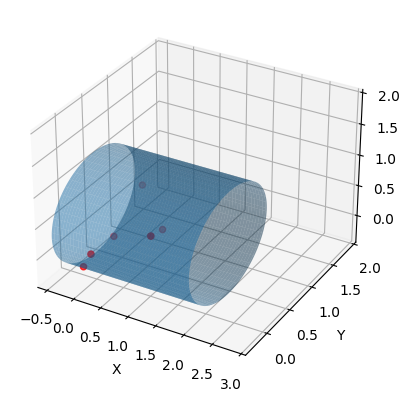

In [ ]:
#@title Demo cell simulation

# init the simulation cylinder
myCylinder = CylinderCell(cylinder_Radius, cylinder_len_x)

# show cylinder
#fig_Volume_Only = myCylinder.plot_cylinder(returnFig=True, show=False)

# init cluster centers
myCylinder.genClusterCentersInCylinder(clusterCenters)

#myCylinder.genOntopBadClusters(clusterCenters)

# show cluster centers
myCylinder.plot_cluster_centers()

# create random normal distributed clusters
#myCylinder.GenRandomClusterNormal(std_x, std_y, std_z, clusterN)
myCylinder.GenGroundTruth_Clusters(std_true, clusterN)
True_Clusters = myCylinder.AddDeviceNoiseToLocalizations(std_x, std_y, std_z)

# plot final clusters
#myCylinder.plot_cluster()

# get some noise
myCylinder.genUniformNoise(noiseN)

# get the data in pandas format
cluster_df = myCylinder.get_cluster_pandas()

# plot interactive 3D
myFig = myCylinder.plot_interactive()


In [ ]:
#@title DBSCAN paramerters
min_num_points = 10 #@param {type: "integer"}
epsilon_xy = 0.05 #@param {type: "number"}
epsilon_z = 0.23 #@param {type: "number"}


In [ ]:
#@title Demo anisotropic clustering
clusters = anisotropicDBSCAN(epsilon_xy, min_num_points, cluster_df, epsilon_z, TwoDMode=False, xCol='x', yCol='y', zCol='z')
for ele in clusters:
        cluster_df.loc[ele[0], 'AnisoLables'] = ele[1]

cluster_df

,x,y,z,label,AnisoLables
0,0.290647,-0.497933,0.385684,0.0,4.0
1,0.220927,-0.488069,0.277384,0.0,4.0
2,0.265990,-0.509528,0.349258,0.0,4.0
3,0.246027,-0.488993,0.220367,0.0,4.0
4,0.226985,-0.530641,0.286532,0.0,4.0
...,...,...,...,...,...
1502,1.688994,0.341250,0.559752,-1.0,0.0
1503,0.215428,-0.084920,1.394820,-1.0,0.0
1504,1.095576,0.289596,0.604284,-1.0,0.0
1505,0.527610,0.018228,0.802702,-1.0,0.0


In [ ]:
#@title Show cluster result

# Plot interactive
fig = go.Figure()

fig.update_layout(title=f'Labled Localizations', autosize=False,
                    width=1500, height=1500,
                    margin=dict(l=65, r=50, b=65, t=90))

fig.add_scatter3d(x=cluster_df.x,
                          y=cluster_df.y,
                          z=cluster_df.z,
                            mode='markers',
                          marker=dict(size=5,
                          color=cluster_df.AnisoLables)
                          ,hovertext=cluster_df.AnisoLables,
                          marker_colorscale=px.colors.qualitative.Plotly)





fig.show()

# Analyze your own data

In [ ]:
#@title Run this first for initialization

# Imports and function definition
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import random
from collections import defaultdict
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
import copy
from sklearn import metrics
from tqdm import tqdm

import plotly.express as px
import plotly.graph_objects as go


#@title Init cluster functions
# Adapted from https://becominghuman.ai/dbscan-clustering-algorithm-implementation-from-scratch-python-9950af5eed97

def check_core_point(eps, minPts, df, index, xCol, yCol, zCol,
                     epsZ=None, TwoDMode=False):

    # 3D case
    if not TwoDMode:
        # get points from given index
        x, y, z = df.iloc[index][xCol], df.iloc[index][yCol], df.iloc[index][zCol]
        # Isotropic case
        if not epsZ:
            dists = np.linalg.norm(df[[xCol, yCol, zCol]].to_numpy() - np.array([x, y, z]), axis=1)
            temp = df[(dists <= eps) & (df.index != index)]
        # Anisotropic case
        else:
            ellipsoid_check = (((df[xCol].to_numpy() - x)**2 / eps**2) + ((df[yCol].to_numpy() - y)**2 / eps**2)
                               + ((df[zCol].to_numpy() - z)**2 / epsZ**2))
            temp = df[(ellipsoid_check <= 1) & (df.index != index)]

    else:
        x, y = df.iloc[index][xCol], df.iloc[index][yCol]
        dists = np.linalg.norm(df[[xCol, yCol]].to_numpy() - np.array([x, y]))
        temp = df[(dists <= eps) & (df.index != index)]

    # check how many points are present within radius
    if len(temp) >= minPts:
        # return format (dataframe, is_core, is_border, is_noise)
        return (temp.index, True, False, False)

    elif (len(temp) < minPts) and len(temp) > 0:
        # return format (dataframe, is_core, is_border, is_noise)
        return (temp.index, False, True, False)

    elif len(temp) == 0:
        # return format (dataframe, is_core, is_border, is_noise)
        return (temp.index, False, False, True)



def anisotropicDBSCAN(eps, minPts, df, epsZ, TwoDMode=False, xCol='x', yCol='y', zCol='z'):
    # initiating cluster number
    C = 1
    # initiating stacks to maintain
    current_stack = set()
    unvisited = list(df.index)
    clusters = []

    show_bar = False

    if show_bar:
        with tqdm(total=len(df.index)) as pbar:
            while (len(unvisited) != 0):  # run until all points have been visited
                pbar.update(1)
                # identifier for first point of a cluster
                first_point = True

                # choose a random unvisited point
                current_stack.add(random.choice(unvisited))

                while len(current_stack) != 0:  # run until a cluster is complete

                    # pop current point from stack
                    curr_idx = current_stack.pop()

                    # check if point is core, neighbour or border
                    neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx, xCol, yCol, zCol,
                                                                                epsZ, TwoDMode)

                    # dealing with an edge case

                    if (isborder & first_point):
                        # for first border point, we label it aand its neighbours as noise
                        clusters.append((curr_idx, 0))
                        clusters.extend(list(zip(neigh_indexes, [0 for _ in range(len(neigh_indexes))])))

                        # label as visited
                        unvisited.remove(curr_idx)
                        unvisited = [e for e in unvisited if e not in neigh_indexes]

                        continue

                    unvisited.remove(curr_idx)  # remove point from unvisited list

                    neigh_indexes = set(neigh_indexes) & set(unvisited)  # look at only unvisited points

                    if iscore:  # if current point is a core
                        first_point = False

                        clusters.append((curr_idx, C))  # assign to a cluster
                        current_stack.update(neigh_indexes)  # add neighbours to a stack

                    elif isborder:  # if current point is a border point
                        clusters.append((curr_idx, C))

                        continue

                    elif isnoise:  # if current point is noise
                        clusters.append((curr_idx, 0))

                        continue

                if not first_point:
                    # increment cluster number
                    C += 1

            return clusters
    else:
        while (len(unvisited) != 0):  # run until all points have been visited
            # identifier for first point of a cluster
            first_point = True

            # choose a random unvisited point
            current_stack.add(random.choice(unvisited))

            while len(current_stack) != 0:  # run until a cluster is complete

                # pop current point from stack
                curr_idx = current_stack.pop()

                # check if point is core, neighbour or border
                neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx, xCol, yCol, zCol,
                                                                            epsZ, TwoDMode)

                # dealing with an edge case

                if (isborder & first_point):
                    # for first border point, we label it aand its neighbours as noise
                    clusters.append((curr_idx, 0))
                    clusters.extend(list(zip(neigh_indexes, [0 for _ in range(len(neigh_indexes))])))

                    # label as visited
                    unvisited.remove(curr_idx)
                    unvisited = [e for e in unvisited if e not in neigh_indexes]

                    continue

                unvisited.remove(curr_idx)  # remove point from unvisited list

                neigh_indexes = set(neigh_indexes) & set(unvisited)  # look at only unvisited points

                if iscore:  # if current point is a core
                    first_point = False

                    clusters.append((curr_idx, C))  # assign to a cluster
                    current_stack.update(neigh_indexes)  # add neighbours to a stack

                elif isborder:  # if current point is a border point
                    clusters.append((curr_idx, C))

                    continue

                elif isnoise:  # if current point is noise
                    clusters.append((curr_idx, 0))

                    continue

            if not first_point:
                # increment cluster number
                C += 1

        return clusters


In [ ]:
#@title Set cluster parameters

file_path = '' #@param {type: "string"}
seperator = ',' #@param {type: "string"}
x_column = 'x' #@param {type: "string"}
y_column = 'y' #@param {type: "string"}
z_column = 'z' #@param {type: "string"}

min_num_points = 10 #@param {type: "integer"}
epsilon_xy = 0.01 #@param {type: "number"}
epsilon_z = 0.013 #@param {type: "number"}

In [ ]:
#@title Run DBSCAN

cluster_df = pd.read_csv(file_path, sep=seperator)

clusters = anisotropicDBSCAN(epsilon_xy, min_num_points, cluster_df, epsilon_z, TwoDMode=False, xCol=x_column, yCol=y_column, zCol=z_column)
for ele in clusters:
        cluster_df.loc[ele[0], 'AnisoLables'] = ele[1]

cluster_df

,x,y,z,label,AnisoLables
0,0.257747,0.003211,0.097006,0.0,3.0
1,0.244280,-0.001388,0.128576,0.0,3.0
2,0.252238,0.003138,0.107014,0.0,3.0
3,0.250143,0.008230,0.132322,0.0,3.0
4,0.251823,-0.002228,0.121313,0.0,3.0
...,...,...,...,...,...
1977,0.613846,0.029020,0.133049,-1.0,0.0
1978,0.769911,0.033309,0.009596,-1.0,0.0
1979,0.172985,-0.036456,0.139806,-1.0,0.0
1980,0.479360,0.048223,0.139429,-1.0,0.0


In [ ]:
#@title Visualize result

# Plot interactive
fig = go.Figure()

fig.update_layout(title=f'Labled Localizations', autosize=False,
                    width=1500, height=1500,
                    margin=dict(l=65, r=50, b=65, t=90))

fig.add_scatter3d(x=cluster_df[x_column],
                          y=cluster_df[y_column],
                          z=cluster_df[z_column],
                          mode='markers',
                          marker=dict(size=5,
                          color=cluster_df.AnisoLables)
                          ,hovertext=cluster_df.AnisoLables,
                          marker_colorscale=px.colors.qualitative.Plotly)





fig.show()

In [ ]:
#@title Save your result

cluster_df.to_csv('./Result.csv')